# Exploratory Data Analysis

This feels a little out of order because I've already done some processing. But that was crucial to be able to look at the data further. With that done, I have a few EDA angles to take here.

1. Look for representation of each schema in my data, and how balanced that representation is.
2. Look at word frequency in my questions, see if anything looks out of whack.
3. Look at similarity between schema titles. I may not fix anything here, but want to know what challenges I may face in modelling, predicting.

## Imports & Data Loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import json
import pickle #for loading processed data

from nltk.probability import FreqDist

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

In [2]:
with open('../data/interim/processed_training_data.pkl', 'rb') as pkl_file:
    training = pickle.load(pkl_file)

training.head()

,schema,question_proc
0,department_management,"[many, head, department, older, 56]"
1,department_management,"[list, name, bear, state, age, head, departmen..."
2,department_management,"[list, creation, year, name, budget, department]"
3,department_management,"[maximum, minimum, budget, department]"
4,department_management,"[average, number, employee, department, whose,..."


## Training Data EDA

### 1. Schema Representation

#### Bring in schema information to compare to training data

In [3]:
schema = pd.read_csv('../data/interim/schema_info.csv')
schema.head()

,schema,table,column_name,column_type,is_primary_key,is_foreign_key,fk_reference_table,fk_reference_column
0,perpetrator,perpetrator,perpetrator_id,numeric,True,False,NaN,NaN
1,perpetrator,perpetrator,people_id,numeric,False,True,people,People_ID
2,perpetrator,perpetrator,date_value,date,False,False,NaN,NaN
3,perpetrator,perpetrator,year,numeric,False,False,NaN,NaN
4,perpetrator,perpetrator,location,text,False,False,NaN,NaN


#### Compare schema in full schema info to schema in training data

In [4]:
#create unique lists of schemas from each source
schema_list = schema['schema'].unique().tolist()
training_list = training['schema'].unique().tolist()

In [5]:
#highlight missing values
missing_values = list(set(schema_list) - set(training_list))

print("These " +str(len(missing_values)) +" schemas are not represented:\n")
print(sorted(missing_values))

These 20 schemas are not represented:

['battle_death', 'car_1', 'concert_singer', 'course_teach', 'cre_Doc_Template_Mgt', 'dog_kennels', 'employee_hire_evaluation', 'flight_2', 'museum_visit', 'network_1', 'orchestra', 'pets_1', 'poker_player', 'real_estate_properties', 'singer', 'student_transcripts_tracking', 'tvshow', 'voter_1', 'world_1', 'wta_1']


In [6]:
#it's possible there may just be some lower vs. upper case issues on some of these? Let's confirm some items.

training.loc[training.schema.str.contains('flight')]['schema'].value_counts()

schema
flight_1          96
flight_4          82
flight_company    19
Name: count, dtype: int64

It really does look like these 20 schemas are missing. I wonder if these are just withheld completely for testing?

If we can't figure out if they are missing for a reason or just due to oversight we could benefit from writing some manual questions before we do a full pre-processing for training.


#### Decision - Write more questions or accept missing schemas

In [7]:
# Pull in test data to see if its represented (is this like seeing the bride before the wedding?)
path = '../data/raw/spider/'

with open(path+'dev.json', "r") as f:
    dev = json.load(f)

In [8]:
#create list of schemas represented
dev_schemas = []

for i in range(len(dev)):
    schem = dev[i]['db_id']
    dev_schemas.append(schem)

In [9]:
#return which values match between our missing in training and our test data
matching = list(set(missing_values) & set(dev_schemas))

print("These " +str(len(matching)) +" schemas are in the test data:\n")
print(sorted(matching))

These 20 schemas are in the test data:

['battle_death', 'car_1', 'concert_singer', 'course_teach', 'cre_Doc_Template_Mgt', 'dog_kennels', 'employee_hire_evaluation', 'flight_2', 'museum_visit', 'network_1', 'orchestra', 'pets_1', 'poker_player', 'real_estate_properties', 'singer', 'student_transcripts_tracking', 'tvshow', 'voter_1', 'world_1', 'wta_1']


They appear to be withheld on purpose. I'll keep moving on!

#### View Distribution of Schemas

Since there are so many, let's group everything that has less than 50 instances.

In [10]:
#set counts into dataframe
counts = training.schema.value_counts().rename_axis('schema').reset_index(name='counts')
counts.head()

,schema,counts
0,scholar,569
1,geo,564
2,academic,181
3,college_2,170
4,college_1,164


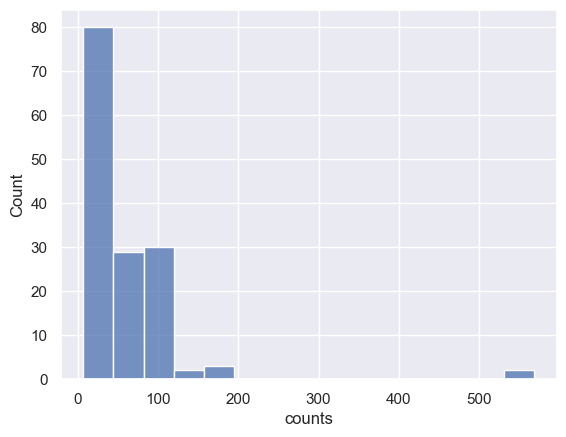

        schema  counts
0      scholar     569
1          geo     564
2     academic     181
3    college_2     170
4    college_1     164
5  restaurants     125
6         hr_1     124
7      store_1     112
8         yelp     111
9         imdb     109


In [11]:
#visualize histogram of schema representation (count)
sns.set(style="darkgrid")

sns.histplot(data=counts, x='counts', bins=15)
plt.show()

print(counts.head(10))

We are very heavy on the scholar and geo dataframes. These aren't part of the main spider data, but from other common datasources added to the project.

Apart from unbalanced classes, this isn't necessarily an issue. We could do a balancing step. But we could also drop these and focus on only the main spider database. I'll come back to that later.

### 2. Question Word Frequency

Here I'll use nltk's "FreqDist" to get our most common words.

In [12]:
#create list of all words
words = training['question_proc']
all_words = []
for wordlist in words:
    all_words += wordlist

In [13]:
all_words[:15]

['many',
 'head',
 'department',
 'older',
 '56',
 'list',
 'name',
 'bear',
 'state',
 'age',
 'head',
 'department',
 'order',
 'age',
 'list']

In [14]:
#breakout the top 25 most common words
common = FreqDist(all_words).most_common(25)
x, y = zip(*common)

In [15]:
type(x)
type(y)

tuple

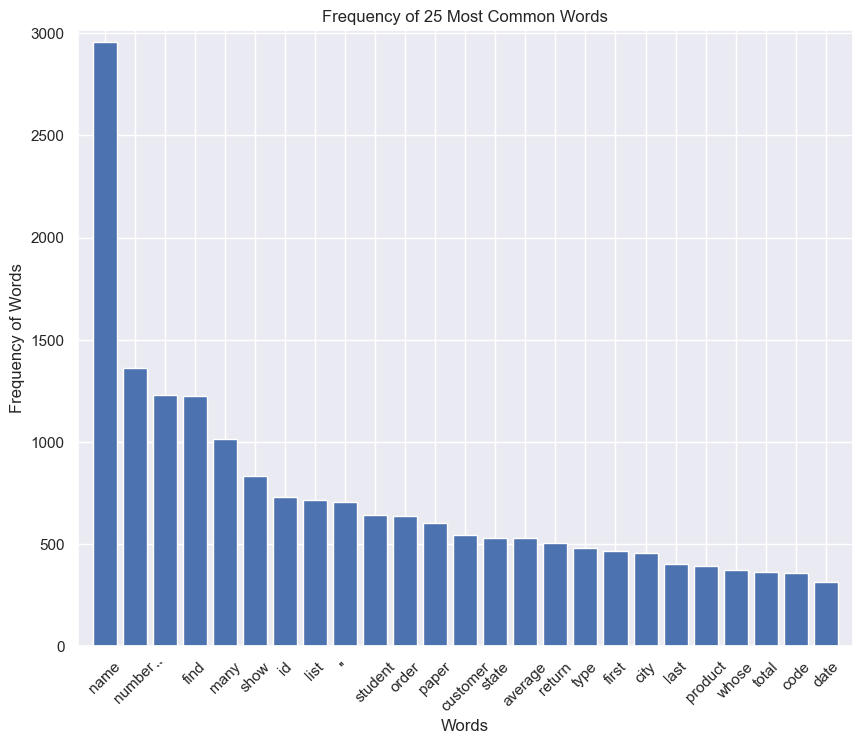

In [16]:
#plot results

plt.figure(figsize=(10,8))
plt.margins(0.02)
plt.bar(x,y)
plt.xlabel('Words')
plt.xticks(rotation=45)
plt.ylabel('Frequency of Words')
plt.title('Frequency of 25 Most Common Words')

plt.show()

**Observations:**
- Name is far and away the most common word in the data. It looks like more than 2x as many as any other word. This is mostly from the questions stating to list the "name" of something, among other things
- There are still some pesky symbols/characters. I'll need to remove those in my final pre-processing
- Just seeing the number of what I would call 'transactional' words - things that drive the question, and aren't necessarilty about the subject matter worries me a bit. I could maybe filter some of those out as domain stopwords 
    - Words like 'how' or 'many', 'average' or 'total' or 'show'

The move could be to set a threshold, and if a words appears in > x% of total quesions then we drop it as too common?

#### Create a list of potential words to remove ontop of regular english stop words in final pre-processing.

In [17]:
#how many total questions in my data?
ques_count = len(training)

In [18]:
#Can't decide between 10 & 5% of records so I'll go middle and set threshold for filtering at 7.5%
threshold = 0.075

#filter wordlist to those with 10% occurence
domain_stops = [word[0] for word in common if word[1] > ques_count*threshold]

domain_stops

['name', 'number', '``', 'find', 'many', 'show', 'id', 'list', "''"]

In [19]:
#remove the non-words from this as we'll already remove that
domain_stops = [word for word in domain_stops if word.isalpha()]

domain_stops

['name', 'number', 'find', 'many', 'show', 'id', 'list']

### 3. Schema Similarity

A list of words isn't totally primed for great similarity comparisons, but I'll try a simple cosine similarity model on the schema names using the sklearn module.

In [20]:
#re-establish my list of schemas
schema_list_sorted = sorted(schema_list)

schema_list_sorted[:5]

['academic', 'activity_1', 'aircraft', 'allergy_1', 'apartment_rentals']

In [21]:
#split out underscores into words with space between
new_list = []
for i in schema_list_sorted:
    k = i.replace("_", " ")
    new_list.append(k)

new_list[:5]

['academic', 'activity 1', 'aircraft', 'allergy 1', 'apartment rentals']

In [22]:
#vectorize my list

vectorizer = CountVectorizer().fit_transform(new_list)
vectors = vectorizer.toarray()
vectors

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [25]:
#create function for comparing two values more naturally
def cosine_sim_vectors(vec1, vec2):
    vec1 = vec1.reshape(1,-1)
    vec2 = vec2.reshape(1,-1)

    return cosine_similarity(vec1, vec2)[0][0]

In [33]:
#do a very simple run through the list in order, comparing with the next alphabetical value. This may not be perfect or complete, but will help me filter down the long list easier.
csim_schemas = [[new_list[i], new_list[i+1], cosine_sim_vectors(vectors[i], vectors[i+1])] for i in range(len(new_list)-1)]

In [41]:
#view csims >= .5 in dataframe
csim_df = pd.DataFrame([schema for schema in csim_schemas if schema[2] >= 0.5], columns=['schema_1','schema_2','cosine_sim'])

csim_df.sort_values(by='cosine_sim', ascending=False).head(30)

,schema_1,schema_2,cosine_sim
0,college 1,college 2,1.000000
8,flight 1,flight 2,1.000000
19,soccer 1,soccer 2,1.000000
16,network 1,network 2,1.000000
15,music 2,music 4,1.000000
14,music 1,music 2,1.000000
1,college 2,college 3,1.000000
9,flight 2,flight 4,1.000000
22,voter 1,voter 2,1.000000
7,election,election representative,0.707107


**Observations**

- Not too many, I probably couldn've just sorted alphabetically and then manually checked, but that was a fun little mini project.
- As expected the schema_n fields should cause issues, but there are others that also might as well.

I had initially thought of having a 2-tiered approach to identifying the target schema. Check for a match with all possible schemas - if there is a runaway winner - go with it. If it is close, expand to search against the table info. But this could still even not be enough if the tables are similar or especially if they're the same. I could maybe even tap into some of the data itself in rare circumstances? But that has to be pretty inefficient. I'll keep doing some research as I move on the with project.